In [1]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.utils import *
from metrics.query import DataFrameQuery
from common.tensor_storage import TensorStorage
from common.metadata_db import MetadataDB
from common.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM, LlamaTokenizer
from IPython.display import display
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from pathlib import Path
import pickle
from collections import Counter

In [2]:
%matplotlib inline

# Functions

In [3]:
def set_dataframes(db) -> pd.DataFrame:
    """
    Aggregate in a dataframe the hidden states of all instances
    ----------
    hidden_states: pd.DataFrame(num_instances, num_layers, model_dim)
    """
    df = pd.read_sql("SELECT * FROM metadata", db.conn)
    df["train_instances"] = df["train_instances"].astype(str)
    df.drop(columns=["id"],inplace = True)
    #import pdb; pdb.set_trace()
    df.drop_duplicates(subset = ["id_instance"],inplace = True, ignore_index = True) # why there are duplicates???
    return df

In [4]:
def tensor_retrieve(dict_query):
    query = DataFrameQuery(dict_query)
    hidden_states,logits, hidden_states_df= hidden_states_collapse(metadata_df,tensor_storage,query)
    return hidden_states,logits,hidden_states_df

In [5]:
def constructing_labels(label: str, hidden_states_df: pd.DataFrame, hidden_states: np.ndarray) -> np.ndarray:
    labels_literals = hidden_states_df[label].unique()
    labels_literals.sort()
    
    map_labels = {class_name: n for n,class_name in enumerate(labels_literals)}
    
    label_per_row = hidden_states_df[label].reset_index(drop=True)
    label_per_row = np.array([map_labels[class_name] for class_name in label_per_row])[:hidden_states.shape[0]]
    
    return label_per_row, map_labels

In [6]:
tsm =  TensorStorageManager()  

In [7]:
def find_identical_rows(matrix):
    # View the rows as a structured array to handle them as tuples
    dtype = [('row', matrix.dtype, matrix.shape[1])]
    structured_array = matrix.view(dtype)
    
    # Find unique rows and their indices
    _, inverse_indices = np.unique(structured_array, return_inverse=True)
    
    # Find where each row appears for the first time and their counts
    unique_rows, counts = np.unique(inverse_indices, return_counts=True)
    
    # Filter out unique rows, keeping only duplicates
    repeated_indices = [np.where(inverse_indices == i)[0] for i in unique_rows[counts > 1]]
    
    return repeated_indices

In [8]:
_PATH = Path("/orfeo/scratch/dssc/zenocosini/mmlu_result/")
result_path = Path(_PATH,"diego")
result_path.mkdir(exist_ok=True,parents=True)
metadata_db = MetadataDB(_PATH / "metadata.db")
metadata_df = set_dataframes(metadata_db)
tensor_storage = TensorStorage(Path(_PATH, "tensor_files"))

# Cluster

### Preprocessing

#### Retrieval

In [9]:
storage_path = Path(f"/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/results/mmlu/llama-2-7b/")

In [10]:
datasets = list(metadata_df["dataset"].unique())
dict_query = { "method":"last",
              "model_name":"meta-llama/Llama-2-7b-hf",
              "train_instances": "5"}
query = DataFrameQuery(dict_query)

In [53]:
hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")

In [54]:
layer = 7

#### Filter identical rows

In [55]:
id_index = find_identical_rows(hidden_states[:,layer,:])

In [56]:
indices_to_exclude = [index[0] for index in id_index]

In [57]:
hd = hidden_states[:, layer, :]
hd = np.delete(hd,indices_to_exclude, axis=0)

#### Retrieve labels

In [156]:
subjects = hidden_states_stat["subjects"]
subjects = np.delete(subjects, indices_to_exclude)
subjects_list = np.unique(subjects)

In [157]:
stem_subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'college_biology', 'college_chemistry',
                 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics',
                 'computer_security', 'conceptual_physics', 'electrical_engineering', 'high_school_biology',
                 'high_school_chemistry', 'high_school_computer_science', 'high_school_mathematics',
                 'high_school_physics', 'high_school_statistics', 'machine_learning', 'medical_genetics',
                 'professional_medicine', 'virology', 'elementary_mathematics']

# Determine STEM and non-STEM
is_stem = np.isin(subjects_list, stem_subjects)
stem = subjects_list[is_stem]
not_stem = subjects_list[~is_stem]

Represent subject as numbers

In [209]:
map_sub_ind = {class_name: n for n,class_name in enumerate(set(subjects))}
map_ind_sub = {n: class_name for n,class_name in enumerate(set(subjects))}
label_per_row = np.array([map_sub_ind[e] for e in subjects])

In [210]:
label_per_row.shape

(14015,)

### Compute

In [160]:
z = 1.2

In [193]:
data = Data(hd)
data.compute_distances(maxk=1000)
clusters_assignement_o = data.compute_clustering_ADP(Z=z)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


#### Filter small clusters

In [211]:
cluster_to_remove = np.where(np.bincount(clusters_assignement)<150)

In [212]:
bad_indices = np.where(np.isin(clusters_assignement, cluster_to_remove[0]))[0]

In [213]:
clusters_assignement = np.delete(clusters_assignement_o, bad_indices)
label_per_row = np.delete(label_per_row, bad_indices)

In [214]:
cluster_sub = np.concatenate([np.expand_dims(label_per_row,axis =0),np.expand_dims(clusters_assignement,axis =0)], axis = 0)
cluster_sub = cluster_sub.T

In [215]:
sub_binary = list(map(lambda r: r in stem,list(map(lambda r: map_ind_sub[r],cluster_sub[:,0]))))

#### Center of cluster based distance

In [216]:
cluster_centers = data.cluster_centers
cluster_centers = np.delete(cluster_centers,cluster_to_remove)
center_coordinates = data.X[cluster_centers] 

In [217]:
distance_matrix_euc_d = pairwise_distances(data.X[cluster_centers], metric='euclidean')

#### Centroids of clusters



In [218]:
indices_per_cluster = data.cluster_indices

In [219]:
centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))

In [220]:
centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
centroids = np.stack(centroids)
centroids = np.delete(centroids,cluster_to_remove, axis=0)
distance_matrix_euc_c = pairwise_distances(centroids, metric='euclidean')

### Plot

In [221]:
df = pd.DataFrame({"type": sub_binary, "cluster": cluster_sub[:,1]})
df["type"] = df["type"].astype(int)

In [222]:
most_represented = df.groupby('cluster')['type'].agg(lambda x: x.mean()).reset_index()


In [223]:
most_represented.rename(columns={"type":"percentage"}, inplace=True)

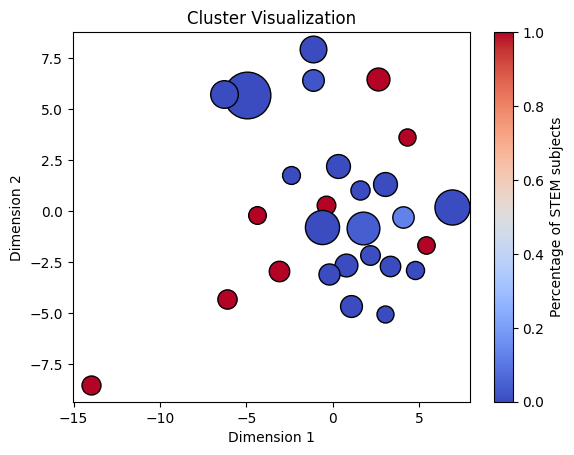

In [224]:
# Example dataset and distance matrix
data_plot = cluster_sub
# distance_matrix = data.log_den_bord
distance_matrix = distance_matrix_euc_c
# Step 1: Count the points in each cluster
cluster_counts = Counter(data_plot[:, 1])

# Prepare counts and labels sorted by cluster index
clusters, counts = zip(*sorted(cluster_counts.items()))

# Step 2: Apply MDS to get 2D positions for each cluster
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
positions = mds.fit_transform(distance_matrix)

# Step 3: Plot each cluster as a circle with area proportional to the count of points
fig, ax = plt.subplots()
# colors = {'STEM': 'blue', 'Non-STEM': 'red'}  # Colors for stem and not stem

# Normalize the color map based on STEM percentages
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.coolwarm  # You can choose any other colormap as needed
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Convert percentages to colors
cluster_colors = scalar_map.to_rgba(most_represented["percentage"])

for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
    # ax.scatter(pos[0], pos[1], s=count, label=f'Cluster {cluster} (n={count})')
    # label = "STEM" if map_ind_sub[sub] in stem_subjects else "Non-STEM"ab
    ax.scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
# from matplotlib.lines import Line2D
# custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['STEM'], markersize=10, label='STEM'),
#                  Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Non-STEM'], markersize=10, label='Non-STEM')]

# Enhance the plot
ax.set_title('Cluster Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#ax.legend(title='Cluster ID (STEM%)', loc='upper left', bbox_to_anchor=(1, 1))
plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
#ax.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 1))

# Show plot
plt.show()


RBF kernel

In [358]:
gamma = 0.001
distance_matrix = distance_matrix_euc
#kernel_matrix = np.exp(-gamma * (distance_matrix) ** 2)
from sklearn.metrics.pairwise import rbf_kernel
kernel_matrix = rbf_kernel(centroids,gamma=gamma)
# from sklearn.metrics.pairwise import polynomial_kernel
# kernel_matrix = polynomial_kernel(distance_matrix, degree=5)
# from sklearn.metrics.pairwise import sigmoid_kernel
# kernel_matrix = sigmoid_kernel(distance_matrix,gamma=gamma)
from sklearn.metrics.pairwise import linear_kernel
kernel_matrix = linear_kernel(centroids)
# from sklearn.metrics.pairwise import chi2_kernel
# kernel_matrix = chi2_kernel(distance_matrix, gamma=.5)
# from sklearn.metrics.pairwise import laplacian_kernel
# kernel_matrix = laplacian_kernel(distance_matrix, gamma=gamma)

In [359]:
kpca = KernelPCA(n_components=2, kernel='precomputed')

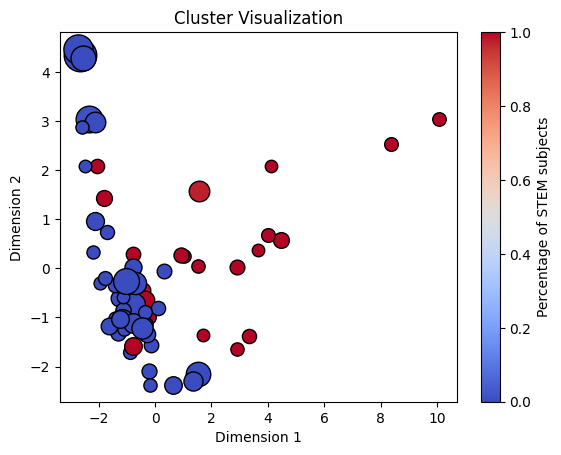

In [361]:
# Example dataset and distance matrix
data_plot = cluster_sub
# distance_matrix = data.log_den_bord

# Step 1: Count the points in each cluster
cluster_counts = Counter(data_plot[:, 1])

# Prepare counts and labels sorted by cluster index
clusters, counts = zip(*sorted(cluster_counts.items()))

positions = kpca.fit_transform(kernel_matrix)

# Step 3: Plot each cluster as a circle with area proportional to the count of points
fig, ax = plt.subplots()
# colors = {'STEM': 'blue', 'Non-STEM': 'red'}  # Colors for stem and not stem

# Normalize the color map based on STEM percentages
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.coolwarm  # You can choose any other colormap as needed
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Convert percentages to colors
cluster_colors = scalar_map.to_rgba(most_represented["percentage"])

for pos, count, cluster, colors in zip(positions, counts, clusters,cluster_colors ):
    # ax.scatter(pos[0], pos[1], s=count, label=f'Cluster {cluster} (n={count})')
    # label = "STEM" if map_ind_sub[sub] in stem_subjects else "Non-STEM"ab
    label = "STEM" if sub else "Non-STEM"
    ax.scatter(pos[0], pos[1], s= count, color=colors, label=label, edgecolors='black', linewidth=1)
# from matplotlib.lines import Line2D
# custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['STEM'], markersize=10, label='STEM'),
#                  Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Non-STEM'], markersize=10, label='Non-STEM')]

# Enhance the plot
ax.set_title('Cluster Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#ax.legend(title='Cluster ID (STEM%)', loc='upper left', bbox_to_anchor=(1, 1))
plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
#ax.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 1))

# Show plot
plt.show()

In [47]:
distance_matrix

array([[-34.57, -21.52, -33.57, ..., -33.57, -33.57, -33.57],
       [-21.52, -34.57, -25.59, ..., -33.57, -33.57, -33.57],
       [-33.57, -25.59, -34.57, ..., -33.57, -33.57, -33.57],
       ...,
       [-33.57, -33.57, -33.57, ..., -34.57, -33.57, -33.57],
       [-33.57, -33.57, -33.57, ..., -33.57, -34.57, -18.78],
       [-33.57, -33.57, -33.57, ..., -33.57, -18.78, -34.57]])

In [85]:
len(data.c)

255